# ImageNet Clarity Classification

This experiment will attempt to classify image clarity by extracting features from different layers of an Xception model. The Xception model will generate features for 128x128 px images, and a classifier will use those feature maps to predict clarity. To fix memory issues, mixed precision training will be used, with Xception using float16 and the classifier using float32.

## Setup

In [1]:
!nvidia-smi

Fri Oct  4 23:11:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:07:00.0 Off |                    0 |
| N/A   36C    P0             43W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !pip install --upgrade pip

In [3]:
# !pip install tensorflow[and-cuda]

In [4]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-10-04 23:11:32.235701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 23:11:32.251188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 23:11:32.255928: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 23:11:32.267859: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 23:11:33.862238: W tensorflow/compiler/tf2

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [6]:
import numpy as np
import keras
from keras import layers, regularizers, mixed_precision
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.utils.class_weight import compute_class_weight
from time import time
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy, Policy

In [7]:
!pwd
!ls koa_scratch

/home/jctactay/photograding/quality
ls: cannot access 'koa_scratch': No such file or directory


In [8]:
policy = Policy('mixed_float16')
set_global_policy(policy)

## Data preprocessing

In [10]:
# load/reconcile labels
cols = ["species","image","focus_clarity"]
labels1 = pd.read_csv('/home/jctactay/photograding/pifsc_labels_detail.csv')[cols]

cols = ["species","filename","focus_clarity"]
labels2 = pd.read_csv('/home/jctactay/photograding/pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","focus_clarity"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)
target_labels = ['2', '4', '8']

In [11]:
print(len(labels))

3592


In [12]:
is_na = labels.focus_clarity.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')
len(labels)

2696

In [13]:
for index, row in labels.iterrows():
    if row.focus_clarity == 2.0:
       labels.at[index, 'focus_clarity'] = 0
    elif row.focus_clarity == 4.0:
        labels.at[index, 'focus_clarity'] = 1
    else:
        labels.at[index, 'focus_clarity'] = 2

In [14]:
value_counts = labels.focus_clarity.value_counts()
value_counts.index = pd.to_numeric(value_counts.index)
value_counts = value_counts.sort_index()
value_counts

focus_clarity
0.0     775
1.0    1420
2.0     501
Name: count, dtype: int64

In [15]:
paths = []
for index, row in labels.iterrows():
    paths.append("/home/jctactay/koa_scratch/images/" + row.image)
assert len(labels) == len(paths)

In [16]:
# image reading/processing
def load_img(path):
    img = Image.open(path)
    img = img.resize((128,128))
    np_img = np.array(img)/127.5 - 1
    return os.path.basename(path), np_img
def load_images_into_dict():
    imgs = {}

    num_workers = 8
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_img = {executor.submit(load_img, path): path for path in paths}

        for future in as_completed(future_to_img):
            img_name, img = future.result()
            imgs[img_name] = img

    return imgs
    
t0 = time()

imgs = load_images_into_dict()
print(f"Done in {time() - t0: .3f}s")

Done in  97.231s


In [17]:
assert len(imgs) == len(labels)

In [18]:
# check for nans
for k, v in zip(imgs.keys(), imgs.values()):
    if np.isnan(v.any()):
        print(k)

In [19]:
print(labels)

                       species                           image  focus_clarity
6     short_finned_pilot_whale              01614d81068ff6.jpg            1.0
10    short_finned_pilot_whale              0246806606bc80.jpg            0.0
15    short_finned_pilot_whale              029eef21f79e91.jpg            0.0
16    short_finned_pilot_whale              02e6e47b13575a.jpg            0.0
17    short_finned_pilot_whale              030acd6311f20a.jpg            0.0
...                        ...                             ...            ...
3587        melon_headed_whale  PIFSC_20110503-S3_C-5088a-.jpg            2.0
3588        melon_headed_whale  PIFSC_20110503-S3_Z-3913a-.jpg            1.0
3589        melon_headed_whale  PIFSC_20110503-S3_Z-3914ed.jpg            1.0
3590        melon_headed_whale  PIFSC_20110503-S3_C-4846a-.jpg            1.0
3591        melon_headed_whale  PIFSC_20110503-S3_Z-3866ed.jpg            2.0

[2696 rows x 3 columns]


In [20]:
Y = labels.focus_clarity
print(np.unique(Y))
X = np.array([imgs[i] for i in labels.image])
print(len(Y))
print(len(X))

[0. 1. 2.]
2696
2696


## Xception model

In [21]:
# load pretrained model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False)
# freeze base model
base_model.trainable = False
base_model.summary(show_trainable=True)

2024-10-04 23:14:36.021274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cast (Cast)       │ (None, 128,     │         0 │ input_layer[0… │   -   │
│                   │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 63, 63,  │       864 │ cast[0][0]     │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_bn   │ (None, 63, 63,  │       128 │ block1_conv1[… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_act  │ (None, 63, 63,  │         0 │ block1_conv1_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 61, 61,  │    18,432 │ block1_conv1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_bn   │ (None, 61, 61,  │       256 │ block1_conv2[… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_act  │ (None, 61, 61,  │         0 │ block1_conv2_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1   │ (None, 61, 61,  │     8,768 │ block1_conv2_… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │         0 │ block2_sepcon… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2   │ (None, 61, 61,  │    17,536 │ block2_sepcon… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 31, 31,  │     8,192 │ block1_conv2_… │   N   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 31, 31,  │         0 │ block2_sepcon… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 31, 31,  │       512 │ conv2d[0][0]   │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 31, 31,  │         0 │ block2_pool[0… │   - 

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

## Helper functions

In [22]:
def plot_history(histories):
    num_subplots = len(histories[0].history.keys())//2 * len(histories)
    fig = plt.figure(figsize=(10,10))
    subfigs = fig.subfigures(num_subplots//2)
    for i, history in enumerate(histories):
        ax = subfigs[i].subplots(1, 2)
        f = 0
        subfigs[i].suptitle(f"Fold {i+1}")
        for metric in history.history.keys():
            ax[f].plot(history.history[metric], label=metric)
            ax[f].legend()
            f = int(not f)

In [23]:
def extract_features(layer_name):
    extractor = keras.Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
    features = extractor.predict(X)
    return features

In [78]:
def build_model(model_arg=None, features=None, num_classes=3):
    if model_arg is None:
        model = keras.Sequential([
            tf.keras.Input(shape=features.shape[1:]),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation='relu', dtype='float32'),
            keras.layers.Dropout(0.3),
            # keras.layers.Dense(100, activation='relu', dtype='float32'),
            # keras.layers.Dropout(0.3),
            keras.layers.Dense(num_classes, activation='softmax', dtype='float32')
        ])
    optimizer = keras.optimizers.Adam(5e-6)
    # optimizer = mixed_precision.LossScaleOptimizer(optimizer)

    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [25]:
def extract_train_predict_cv(layer_name, callback_arg=None, model_arg=None, n_splits=5):
    features = extract_features(layer_name)
    print("Shape of features:", features.shape)
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    classes = np.unique(Y)
    num_classes = len(classes)
    fold_no = 1
    all_preds = np.zeros((X.shape[0], num_classes))
    histories = []
    for train_index, val_index in cv.split(X=features,y=Y):
        model = build_model(model_arg, features, num_classes)
        if callback_arg is None:
            callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=5)
        print(f'Training on fold {fold_no}...')
        X_train, X_val = features[train_index], features[val_index]
        Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
        print("Class weights:", class_weights)
        class_weights_dict = dict(zip(np.unique(Y_train), class_weights))
        sample_weights = np.array([class_weights_dict[label] for label in Y_train])
        history = model.fit(X_train, Y_train, batch_size=32, epochs=30, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)
        histories.append(history)
        pred_soft = model.predict(X_val)
        all_preds[val_index] = pred_soft
        fold_no += 1
    preds = np.argmax(all_preds, axis=1)
    report = classification_report(Y, preds, target_names=target_labels)
    cm = confusion_matrix(Y, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
    return histories, report, disp

## block5_sepconv1_act (baseline)

Treat this layer as the baseline based on overall feature extraction experiment

In [112]:
histories, report, disp = extract_train_predict_cv('block5_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.3737 - loss: 1.5370 - val_accuracy: 0.4494 - val_loss: 1.2081
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4603 - loss: 1.1745 - val_accuracy: 0.4160 - val_loss: 1.2246
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4727 - loss: 1.1558 - val_accuracy: 0.4016 - val_loss: 1.2355
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4859 - loss: 1.0727 - val_accuracy: 0.4505 - val_loss: 1.1763
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5281 - loss: 1.0099 - val_accuracy: 0.4716 - val_loss: 1.1586
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5733 - loss: 0.9619 - val_accuracy: 0.4961 - val_loss: 1.1380
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6038 - loss: 0.9326 - val_accu

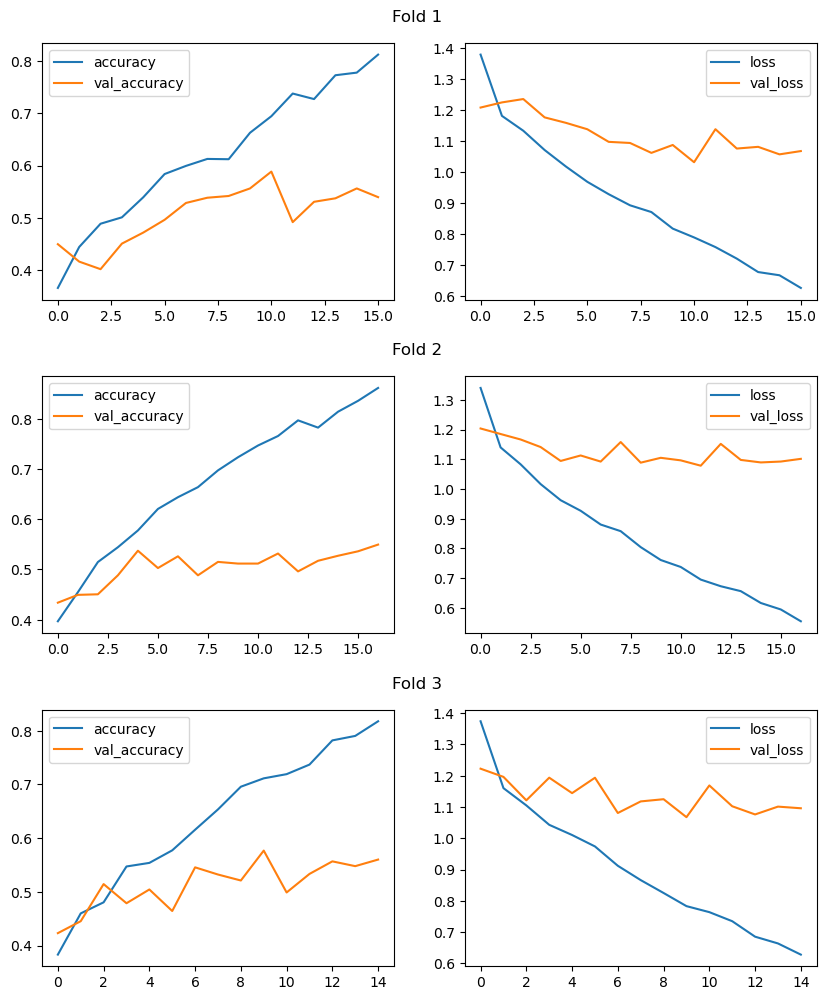

In [113]:
plot_history(histories)

In [114]:
print(report)

              precision    recall  f1-score   support

           2       0.58      0.53      0.56       775
           4       0.60      0.62      0.61      1420
           8       0.44      0.47      0.45       501

    accuracy                           0.57      2696
   macro avg       0.54      0.54      0.54      2696
weighted avg       0.57      0.57      0.57      2696



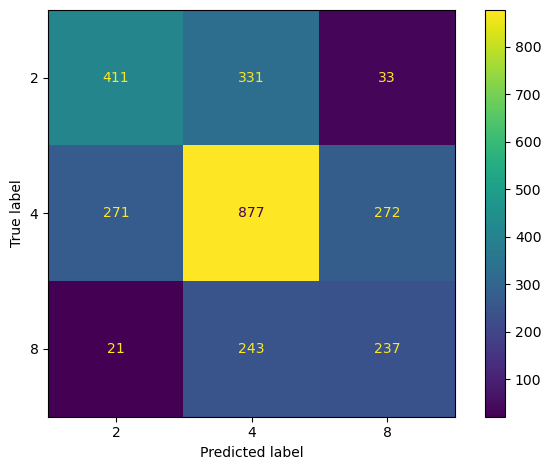

In [115]:
disp.plot()
plt.tight_layout()

## block4_sepconv1_act

In [116]:
histories, report, disp = extract_train_predict_cv('block4_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Shape of features: (2696, 16, 16, 256)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.3522 - loss: 2.1481 - val_accuracy: 0.3815 - val_loss: 1.2931
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4089 - loss: 1.2966 - val_accuracy: 0.4227 - val_loss: 1.2793
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4374 - loss: 1.2100 - val_accuracy: 0.3782 - val_loss: 1.2945
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4420 - loss: 1.1814 - val_accuracy: 0.3704 - val_loss: 1.3181
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4805 - loss: 1.1596 - val_accuracy: 0.4249 - val_loss: 1.2659
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4960 - loss: 1.1219 - val_accuracy: 0.4894 - val_loss: 1.1803
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5409 - loss: 1.1404 - val_ac

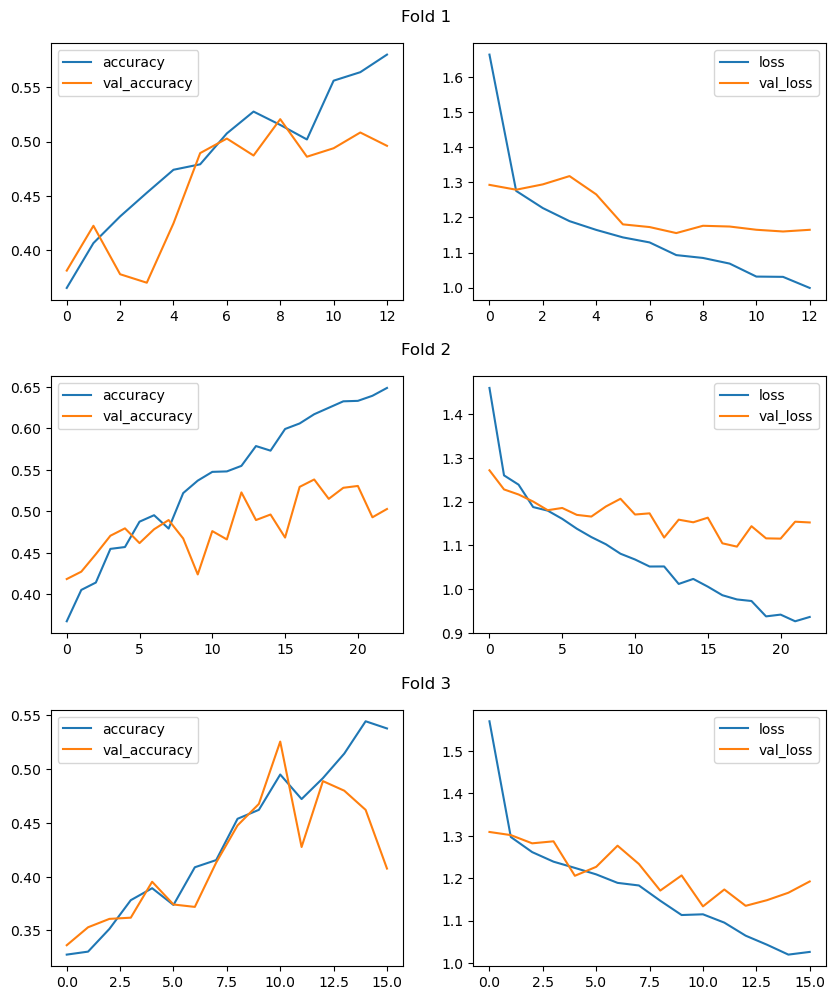

In [117]:
plot_history(histories)

In [118]:
print(report)

              precision    recall  f1-score   support

           2       0.51      0.58      0.54       775
           4       0.57      0.52      0.55      1420
           8       0.39      0.41      0.40       501

    accuracy                           0.52      2696
   macro avg       0.49      0.50      0.50      2696
weighted avg       0.52      0.52      0.52      2696



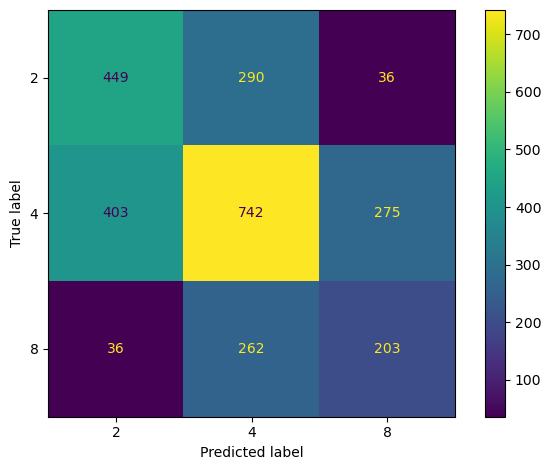

In [119]:
disp.plot()
plt.tight_layout()

## block4_sepconv2_act

In [120]:
histories, report, disp = extract_train_predict_cv('block4_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Shape of features: (2696, 16, 16, 728)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.3739 - loss: 1.5000 - val_accuracy: 0.5150 - val_loss: 1.3046
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5281 - loss: 1.2356 - val_accuracy: 0.4638 - val_loss: 1.3379
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5783 - loss: 1.1282 - val_accuracy: 0.5106 - val_loss: 1.2700
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6545 - loss: 1.0206 - val_accuracy: 0.4983 - val_loss: 1.2795
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6827 - loss: 0.9782 - val_accuracy: 0.5662 - val_loss: 1.2165
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8004 - loss: 0.8304 - val_accuracy: 0.5562 - val_loss: 1.2232
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8510 - loss: 0.7466 - 

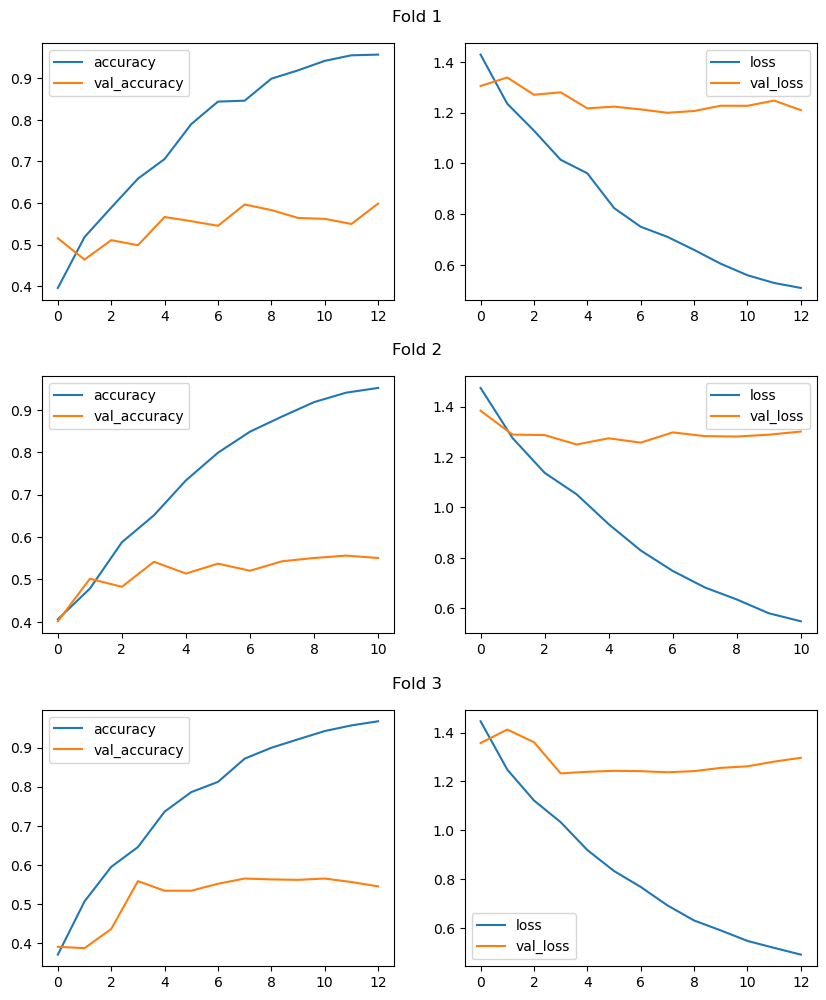

In [121]:
plot_history(histories)

In [122]:
print(report)

              precision    recall  f1-score   support

           2       0.55      0.52      0.54       775
           4       0.59      0.69      0.64      1420
           8       0.46      0.29      0.36       501

    accuracy                           0.57      2696
   macro avg       0.54      0.50      0.51      2696
weighted avg       0.56      0.57      0.56      2696



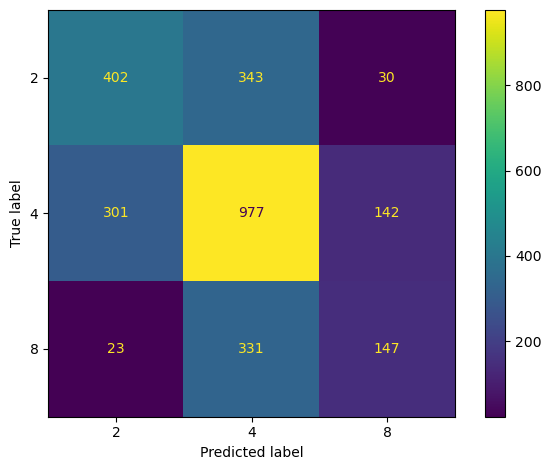

In [123]:
disp.plot()
plt.tight_layout()

## block11_sepconv1_act

In [124]:
history, report, disp = extract_train_predict_cv('block11_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.3602 - loss: 1.7538 - val_accuracy: 0.4049 - val_loss: 1.2933
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4715 - loss: 1.1620 - val_accuracy: 0.4661 - val_loss: 1.1616
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5065 - loss: 1.0661 - val_accuracy: 0.4750 - val_loss: 1.1487
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5646 - loss: 0.9954 - val_accuracy: 0.4950 - val_loss: 1.1268
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6004 - loss: 0.9228 - val_accuracy: 0.5228 - val_loss: 1.0952
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6655 - loss: 0.8702 - val_accuracy: 0.5172 - val_loss: 1.1142
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6581 - loss: 0.8302 - val_accu

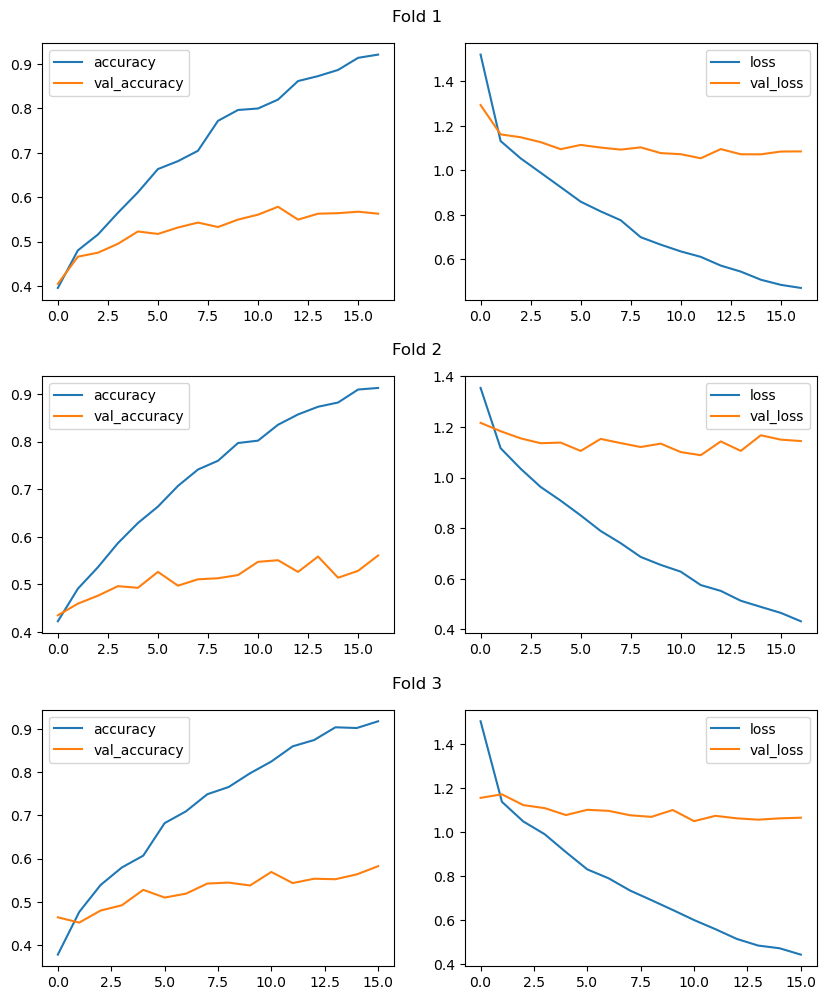

In [125]:
plot_history(history)

In [126]:
print(report)

              precision    recall  f1-score   support

           2       0.55      0.59      0.57       775
           4       0.61      0.60      0.61      1420
           8       0.47      0.41      0.44       501

    accuracy                           0.57      2696
   macro avg       0.54      0.54      0.54      2696
weighted avg       0.56      0.57      0.56      2696



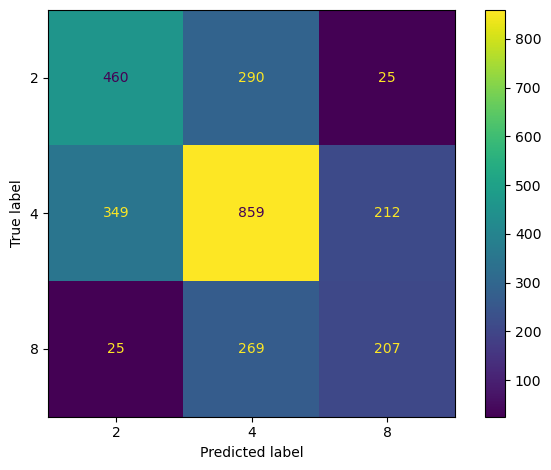

In [127]:
disp.plot()
plt.tight_layout()

## block10_sepconv3_act

In [128]:
history, report, disp = extract_train_predict_cv('block10_sepconv3_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.3722 - loss: 1.2947 - val_accuracy: 0.4472 - val_loss: 1.1764
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4952 - loss: 1.1267 - val_accuracy: 0.4527 - val_loss: 1.1537
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5163 - loss: 1.0702 - val_accuracy: 0.4505 - val_loss: 1.1509
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5524 - loss: 0.9980 - val_accuracy: 0.4850 - val_loss: 1.1143
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5761 - loss: 0.9664 - val_accuracy: 0.4950 - val_loss: 1.1091
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6177 - loss: 0.9044 - val_accuracy: 0.5028 - val_loss: 1.0934
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6434 - loss: 0.8821 - val_accu

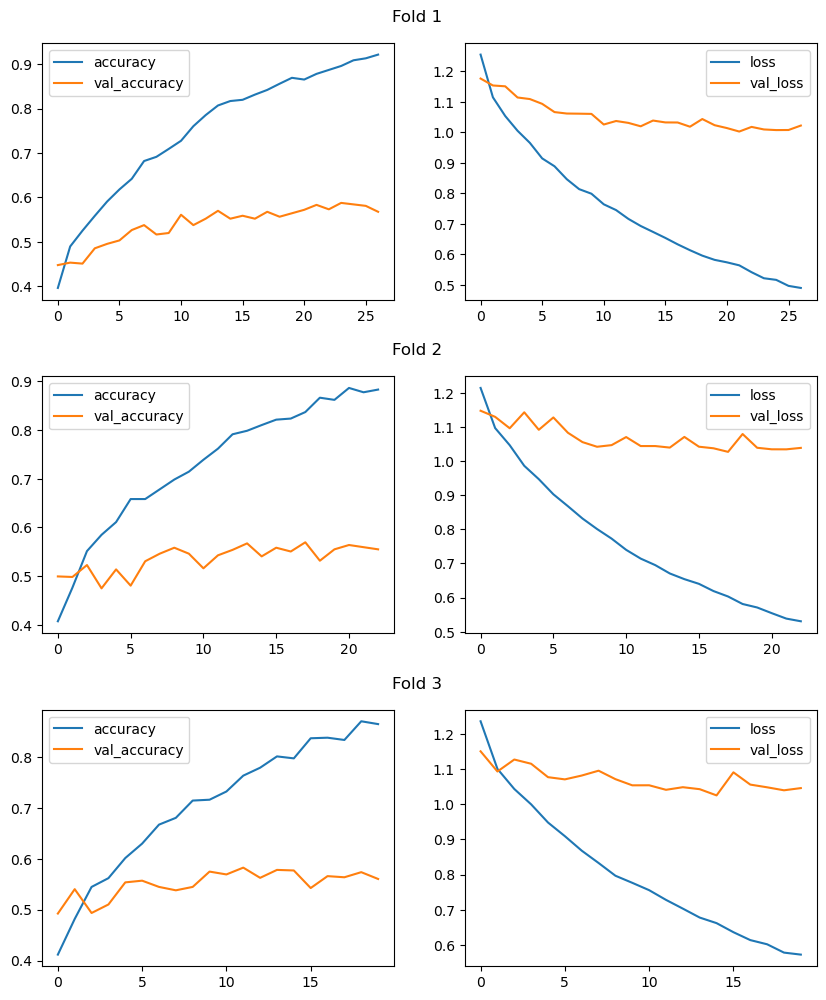

In [129]:
plot_history(history)

In [130]:
print(report)

              precision    recall  f1-score   support

           2       0.58      0.61      0.59       775
           4       0.62      0.60      0.61      1420
           8       0.45      0.44      0.45       501

    accuracy                           0.58      2696
   macro avg       0.55      0.55      0.55      2696
weighted avg       0.58      0.58      0.58      2696



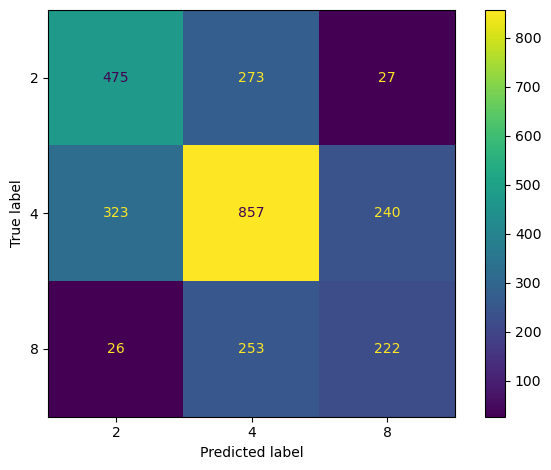

In [131]:
disp.plot()
plt.tight_layout()

## block8_sepconv1_act

In [132]:
history, report, disp = extract_train_predict_cv('block8_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.3526 - loss: 1.7683 - val_accuracy: 0.4583 - val_loss: 1.1565
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4637 - loss: 1.1622 - val_accuracy: 0.4283 - val_loss: 1.1929
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5169 - loss: 1.0415 - val_accuracy: 0.4672 - val_loss: 1.1699
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5336 - loss: 1.0144 - val_accuracy: 0.4650 - val_loss: 1.1528
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5825 - loss: 0.9638 - val_accuracy: 0.5239 - val_loss: 1.0744
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6534 - loss: 0.9043 - val_accuracy: 0.5139 - val_loss: 1.1089
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6663 - loss: 0.8291 - val_accu

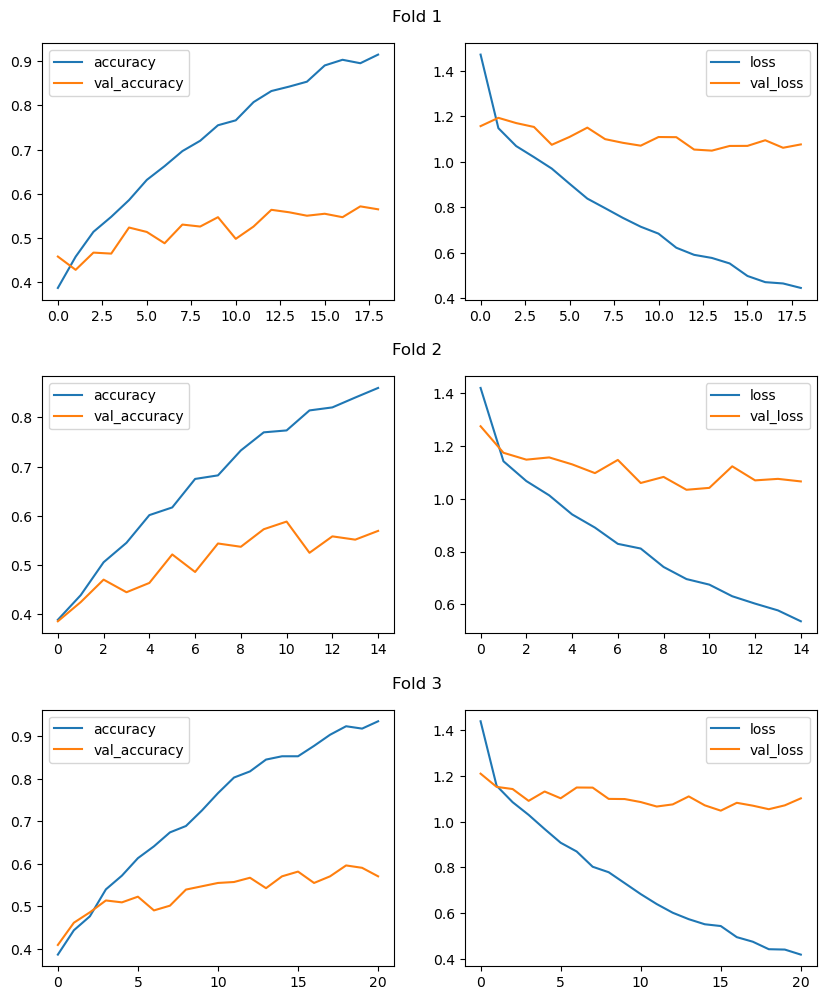

In [133]:
plot_history(history)

In [134]:
print(report)

              precision    recall  f1-score   support

           2       0.55      0.59      0.57       775
           4       0.61      0.61      0.61      1420
           8       0.48      0.45      0.46       501

    accuracy                           0.57      2696
   macro avg       0.55      0.55      0.55      2696
weighted avg       0.57      0.57      0.57      2696



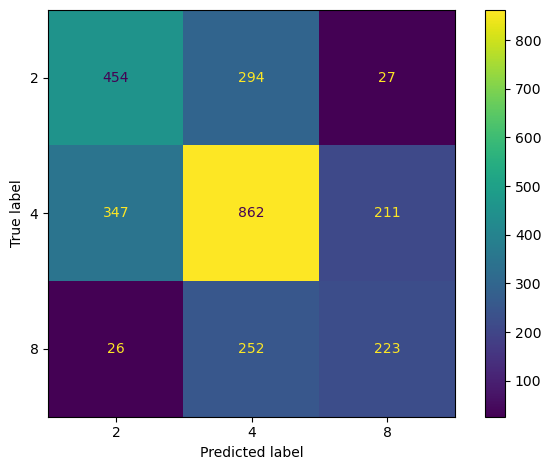

In [135]:
disp.plot()
plt.tight_layout()

## block6_sepconv1_act

In [144]:
history, report, disp = extract_train_predict_cv('block6_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.3833 - loss: 1.3931 - val_accuracy: 0.3982 - val_loss: 1.2544
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4407 - loss: 1.1508 - val_accuracy: 0.4305 - val_loss: 1.1868
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4939 - loss: 1.0930 - val_accuracy: 0.4705 - val_loss: 1.1470
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5525 - loss: 1.0192 - val_accuracy: 0.4516 - val_loss: 1.1676
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5732 - loss: 0.9656 - val_accuracy: 0.4972 - val_loss: 1.1702
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6363 - loss: 0.9022 - val_accuracy: 0.4650 - val_loss: 1.1573
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6483 - loss: 0.8611 - val_accu

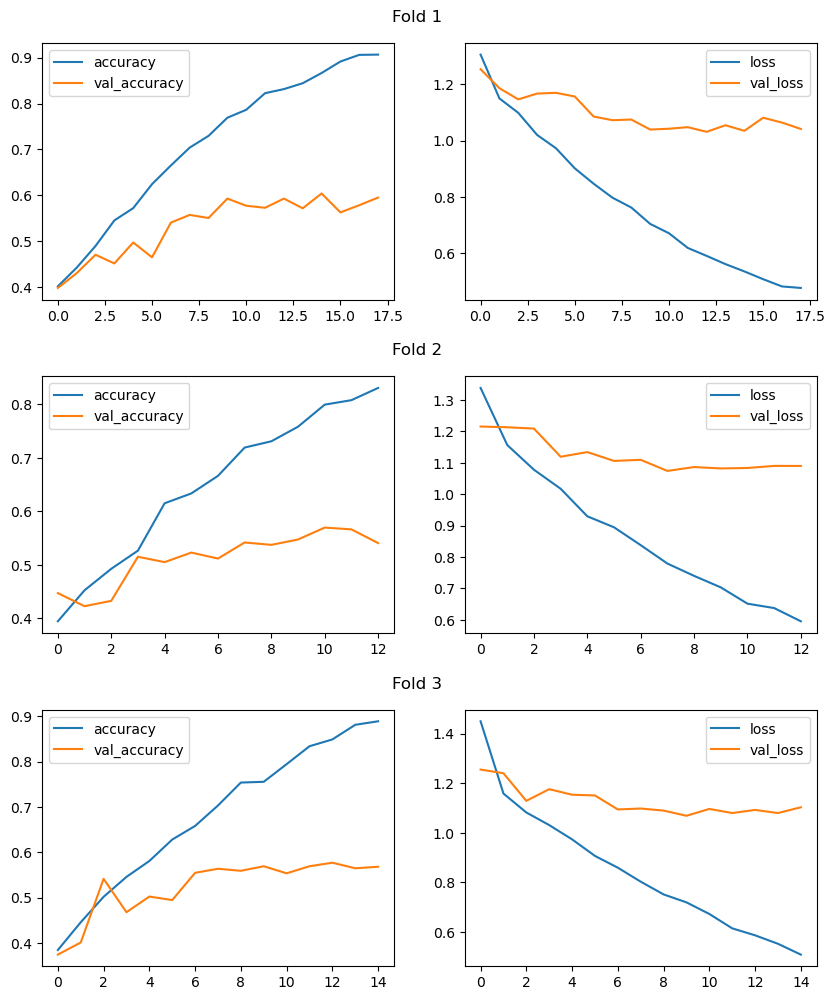

In [145]:
plot_history(history)

In [146]:
print(report)

              precision    recall  f1-score   support

           2       0.57      0.57      0.57       775
           4       0.60      0.62      0.61      1420
           8       0.45      0.42      0.43       501

    accuracy                           0.57      2696
   macro avg       0.54      0.54      0.54      2696
weighted avg       0.57      0.57      0.57      2696



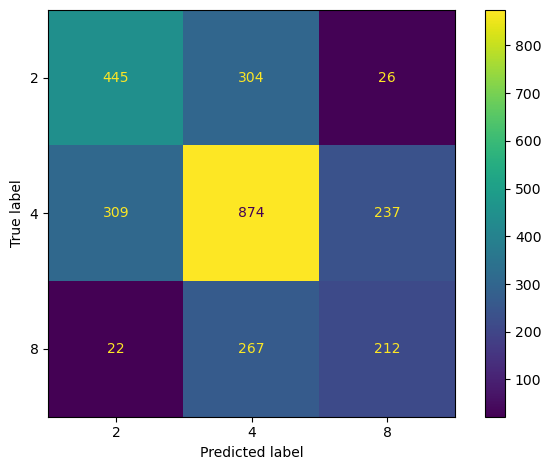

In [147]:
disp.plot()
plt.tight_layout()

## block6_sepconv2_act (best so far)

In [79]:
history, report, disp = extract_train_predict_cv('block6_sepconv2_act')

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [1.15913978 0.63262911 1.79666667]
Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.3877 - loss: 1.0883 - val_accuracy: 0.5204 - val_loss: 0.9233
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5502 - loss: 0.8432 - val_accuracy: 0.5426 - val_loss: 0.8936
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6317 - loss: 0.7329 - val_accuracy: 0.5185 - val_loss: 0.9379
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6532 - loss: 0.6708 - val_accuracy: 0.5444 - val_loss: 0.8545
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7111 - loss: 0.5999 - val_accuracy: 0.5222 - val_loss: 0.9413
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7509 - loss: 0.5393 - val_accuracy: 0.5556 - val_loss: 0.8941
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8222 - loss: 0.4738 - val_accu

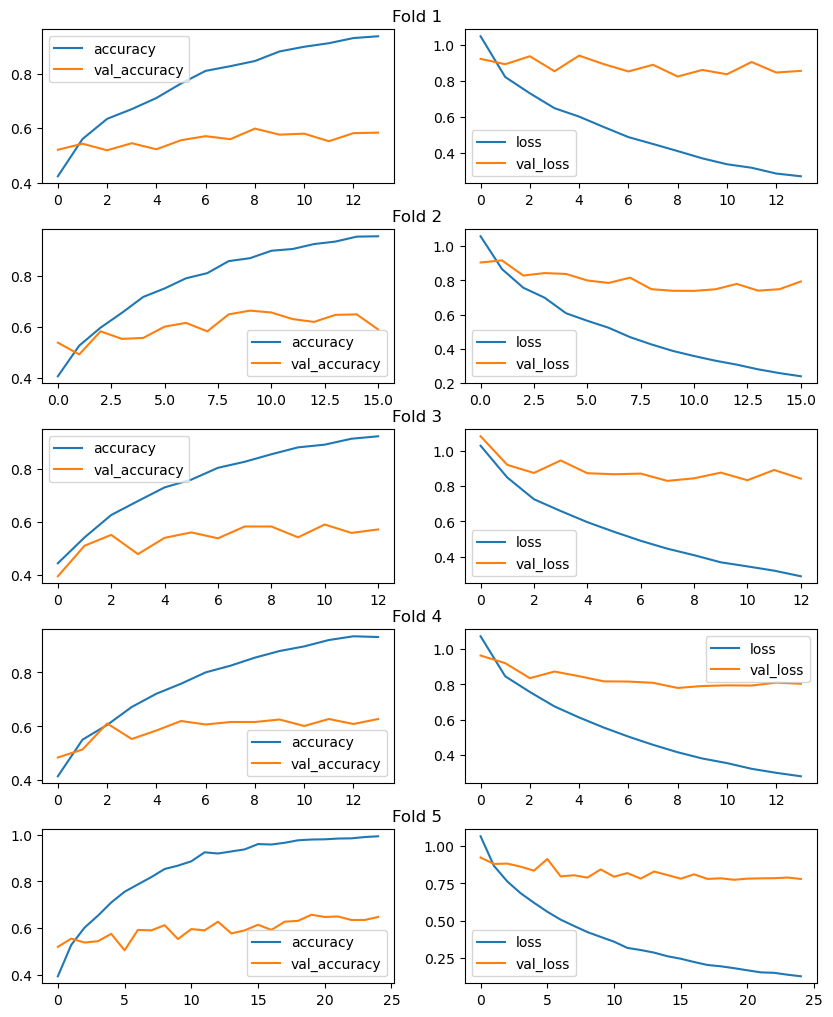

In [80]:
plot_history(history)

In [81]:
print(report)

              precision    recall  f1-score   support

           2       0.63      0.58      0.60       775
           4       0.64      0.69      0.67      1420
           8       0.55      0.49      0.52       501

    accuracy                           0.62      2696
   macro avg       0.61      0.59      0.59      2696
weighted avg       0.62      0.62      0.62      2696



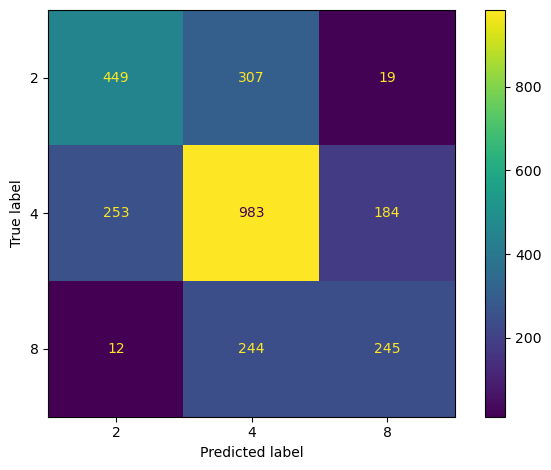

In [82]:
disp.plot()
plt.tight_layout()

## block6_sepconv3_act

In [140]:
histories, report, disp = extract_train_predict_cv('block6_sepconv3_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4056 - loss: 1.2802 - val_accuracy: 0.4638 - val_loss: 1.1714
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5077 - loss: 1.1025 - val_accuracy: 0.4727 - val_loss: 1.1383
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5565 - loss: 1.0126 - val_accuracy: 0.5128 - val_loss: 1.0990
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6018 - loss: 0.9662 - val_accuracy: 0.5206 - val_loss: 1.0904
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6223 - loss: 0.9218 - val_accuracy: 0.5729 - val_loss: 1.0429
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6837 - loss: 0.8730 - val_accuracy: 0.5551 - val_loss: 1.0478
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7002 - loss: 0.8335 - val_accu

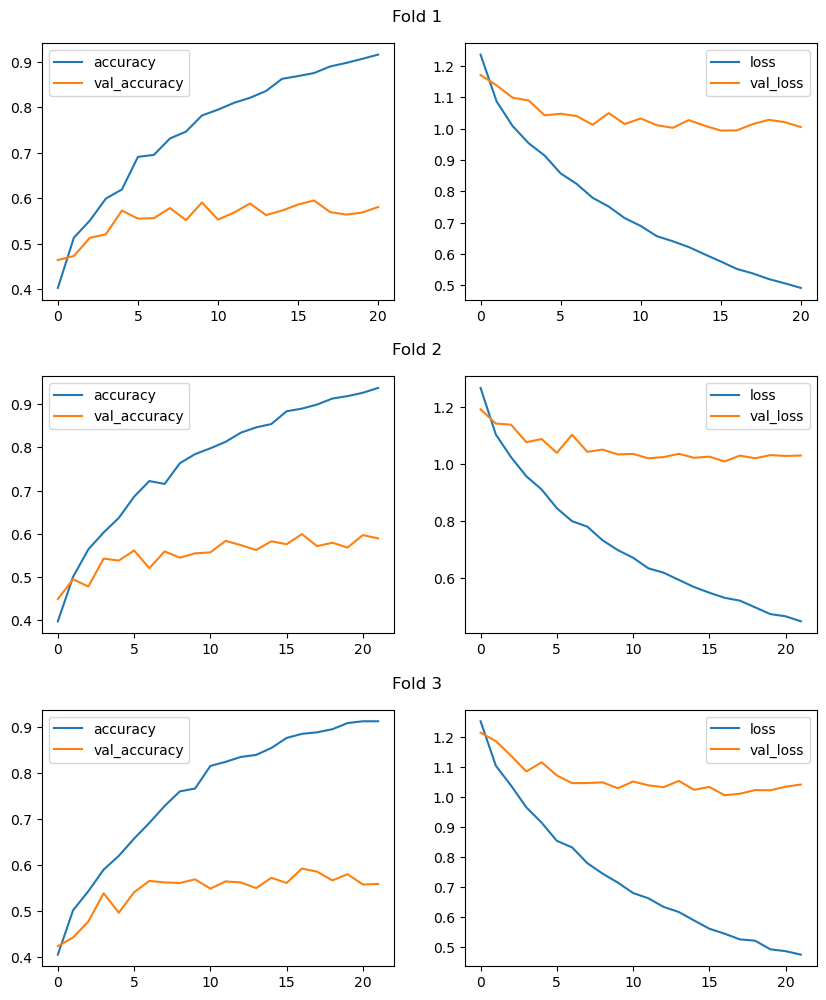

In [141]:
plot_history(histories)

In [142]:
print(report)

              precision    recall  f1-score   support

           2       0.59      0.60      0.59       775
           4       0.63      0.63      0.63      1420
           8       0.50      0.48      0.49       501

    accuracy                           0.59      2696
   macro avg       0.57      0.57      0.57      2696
weighted avg       0.59      0.59      0.59      2696



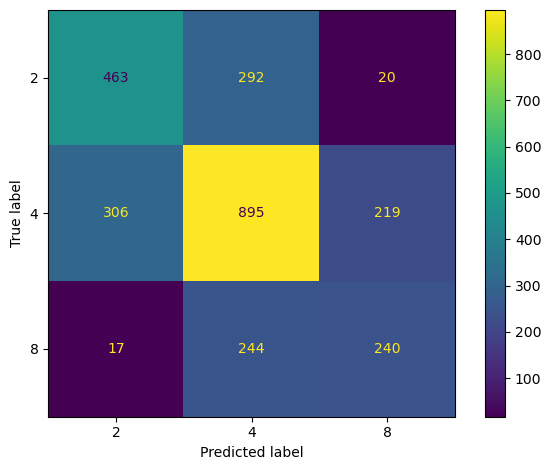

In [143]:
disp.plot()
plt.tight_layout()

Block 6 seemed to have overall best performance; image clarity may be mid- to high-lvl feature

## block1_conv2_act

In [98]:
histories, report, disp = extract_train_predict_cv('block1_conv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Shape of features: (2696, 61, 61, 64)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.3446 - loss: 2.4037 - val_accuracy: 0.3871 - val_loss: 1.4166
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3507 - loss: 1.4048 - val_accuracy: 0.3893 - val_loss: 1.4248
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4175 - loss: 1.3573 - val_accuracy: 0.4616 - val_loss: 1.3338
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4261 - loss: 1.3240 - val_accuracy: 0.3637 - val_loss: 1.3837
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3881 - loss: 1.2664 - val_accuracy: 0.5095 - val_loss: 1.2690
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4341 - loss: 1.2466 - val_accuracy: 0.3927 - val_loss: 1.3376
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4058 - loss: 1.2144 - v

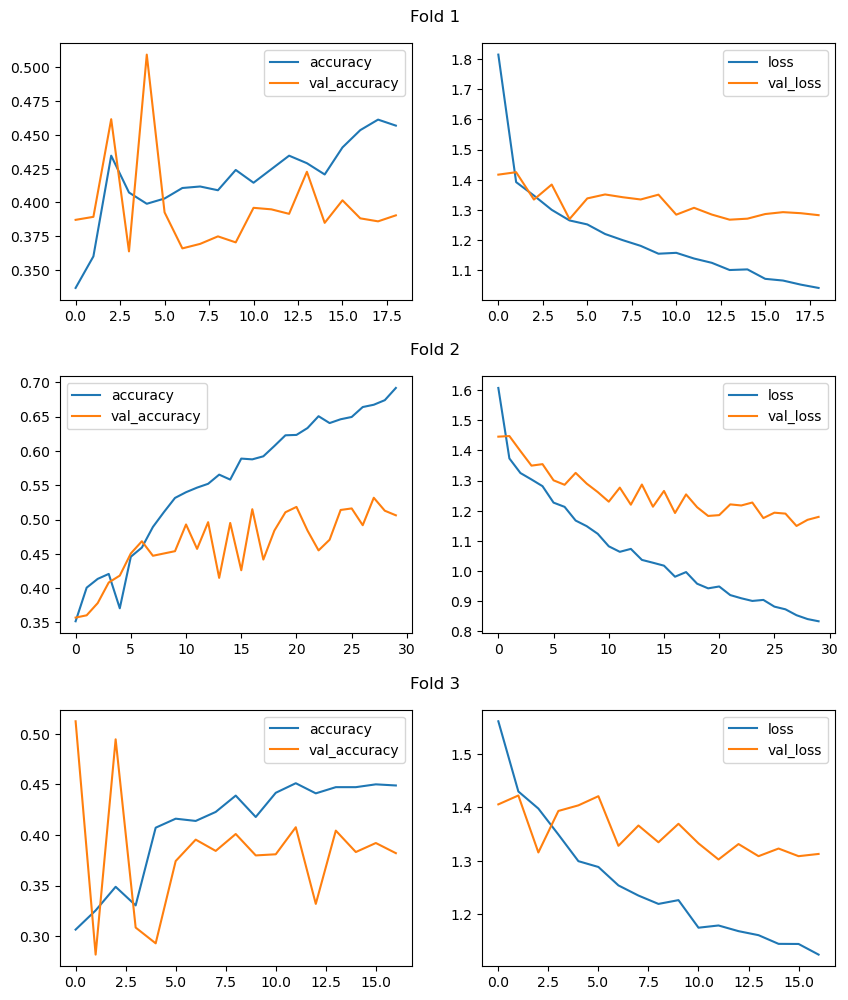

In [99]:
plot_history(histories)

In [100]:
print(report)

              precision    recall  f1-score   support

           2       0.46      0.68      0.55       775
           4       0.58      0.28      0.38      1420
           8       0.35      0.60      0.44       501

    accuracy                           0.45      2696
   macro avg       0.46      0.52      0.46      2696
weighted avg       0.50      0.45      0.44      2696



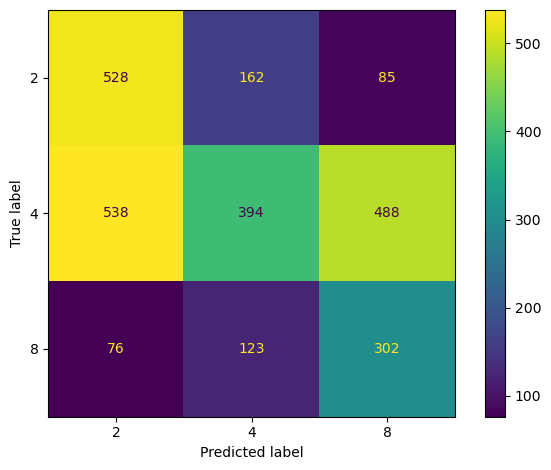

In [101]:
disp.plot()
plt.tight_layout()

## block2_sepconv2_act

In [102]:
histories, report, disp = extract_train_predict_cv('block2_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Shape of features: (2696, 61, 61, 128)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.2909 - loss: 1.9382 - val_accuracy: 0.1869 - val_loss: 1.6439
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.2625 - loss: 1.6414 - val_accuracy: 0.3003 - val_loss: 1.6352
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3477 - loss: 1.5573 - val_accuracy: 0.2514 - val_loss: 1.6486
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3360 - loss: 1.5640 - val_accuracy: 0.2859 - val_loss: 1.6187
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3475 - loss: 1.5053 - val_accuracy: 0.2636 - val_loss: 1.6328
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3753 - loss: 1.4319 - val_accuracy: 0.2625 - val_loss: 1.6805
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4700 - loss: 1.3898 

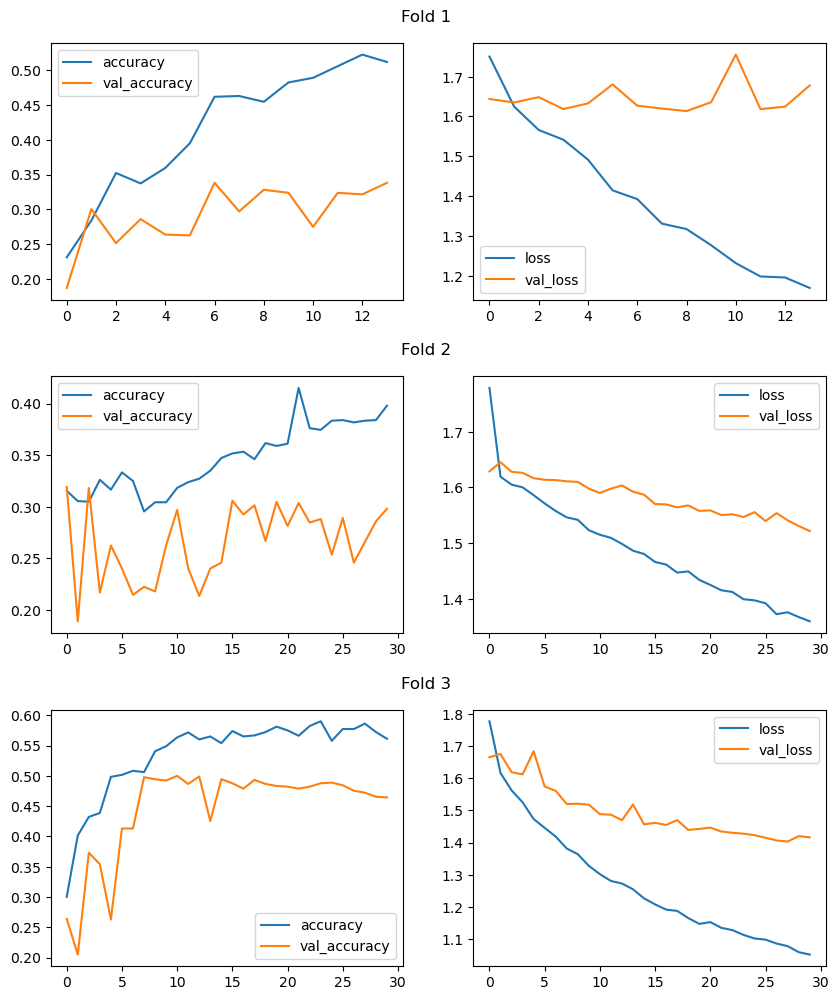

In [103]:
plot_history(histories)

In [104]:
print(report)

              precision    recall  f1-score   support

           2       0.41      0.39      0.40       775
           4       0.54      0.24      0.33      1420
           8       0.26      0.70      0.38       501

    accuracy                           0.37      2696
   macro avg       0.41      0.44      0.37      2696
weighted avg       0.45      0.37      0.36      2696



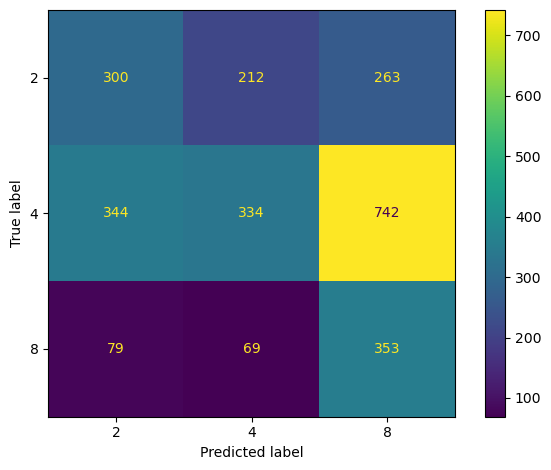

In [105]:
disp.plot()
plt.tight_layout()

## block3_sepconv2_act

In [89]:
histories, report, disp = extract_train_predict_cv('block3_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Shape of features: (2696, 31, 31, 256)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.3089 - loss: 1.7712 - val_accuracy: 0.2892 - val_loss: 1.4952
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3353 - loss: 1.4267 - val_accuracy: 0.3226 - val_loss: 1.4905
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3262 - loss: 1.4401 - val_accuracy: 0.3726 - val_loss: 1.4191
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3774 - loss: 1.3896 - val_accuracy: 0.3938 - val_loss: 1.4320
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4099 - loss: 1.3315 - val_accuracy: 0.3660 - val_loss: 1.4376
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3952 - loss: 1.3246 - val_accuracy: 0.4472 - val_loss: 1.3380
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4255 - loss: 1.2781 - 

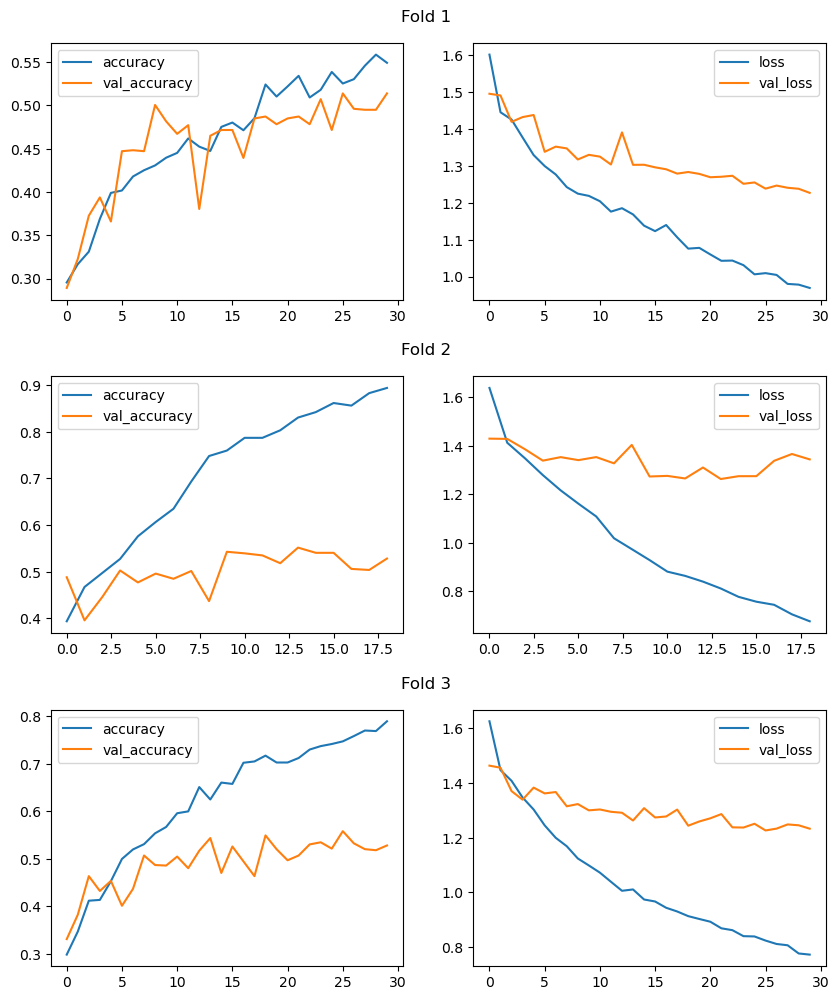

In [90]:
plot_history(histories)

In [92]:
print(report)

              precision    recall  f1-score   support

           2       0.50      0.61      0.55       775
           4       0.61      0.54      0.57      1420
           8       0.45      0.45      0.45       501

    accuracy                           0.54      2696
   macro avg       0.52      0.53      0.52      2696
weighted avg       0.55      0.54      0.54      2696



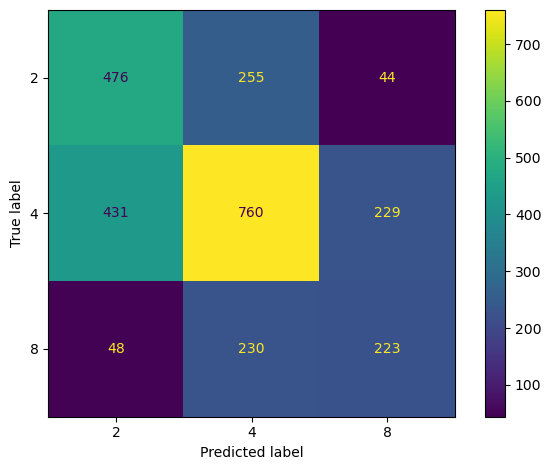

In [93]:
disp.plot()
plt.tight_layout()

## block3_sepconv1_act

In [86]:
histories, report, disp = extract_train_predict_cv('block3_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Shape of features: (2696, 31, 31, 128)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.3406 - loss: 2.2289 - val_accuracy: 0.3826 - val_loss: 1.3785
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4743 - loss: 1.3752 - val_accuracy: 0.4950 - val_loss: 1.3695
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4451 - loss: 1.3362 - val_accuracy: 0.3181 - val_loss: 1.3642
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2346 - loss: 1.3430 - val_accuracy: 0.3226 - val_loss: 1.3565
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2697 - loss: 1.3368 - val_accuracy: 0.3281 - val_loss: 1.3540
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3424 - loss: 1.3503 - val_accuracy: 0.3315 - val_loss: 1.3432
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3164 - loss: 1.3381 - v

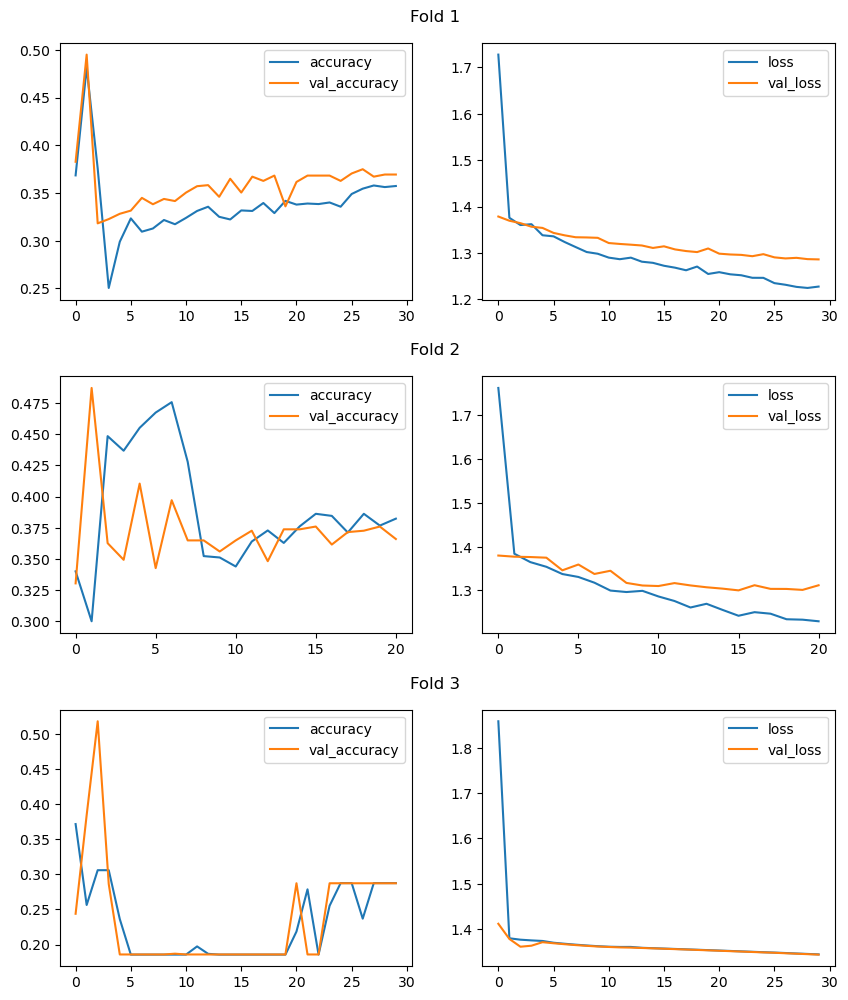

In [87]:
plot_history(histories)

In [ ]:
print(report)

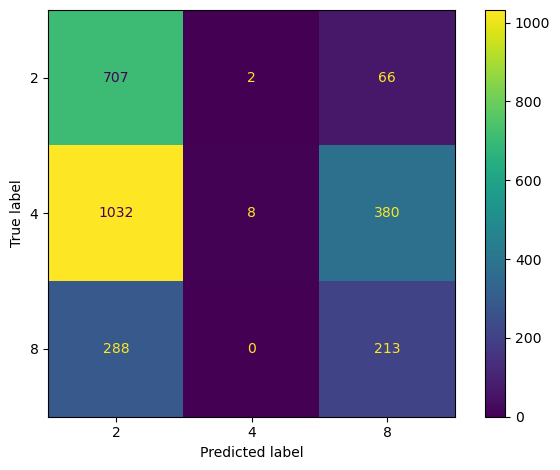

In [88]:
disp.plot()
plt.tight_layout()

## block13_sepconv1_act

Clarity may be a high level feature; testing exit flow layers

In [148]:
histories, report, disp = extract_train_predict_cv('block13_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.3692 - loss: 1.8066 - val_accuracy: 0.4249 - val_loss: 1.2797
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4589 - loss: 1.1755 - val_accuracy: 0.4661 - val_loss: 1.1861
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5539 - loss: 1.0721 - val_accuracy: 0.4627 - val_loss: 1.1725
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5621 - loss: 1.0127 - val_accuracy: 0.4972 - val_loss: 1.1528
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6056 - loss: 0.9324 - val_accuracy: 0.4961 - val_loss: 1.1622
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6526 - loss: 0.8594 - val_accuracy: 0.5273 - val_loss: 1.1192
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6864 - loss: 0.8218 - val_accu

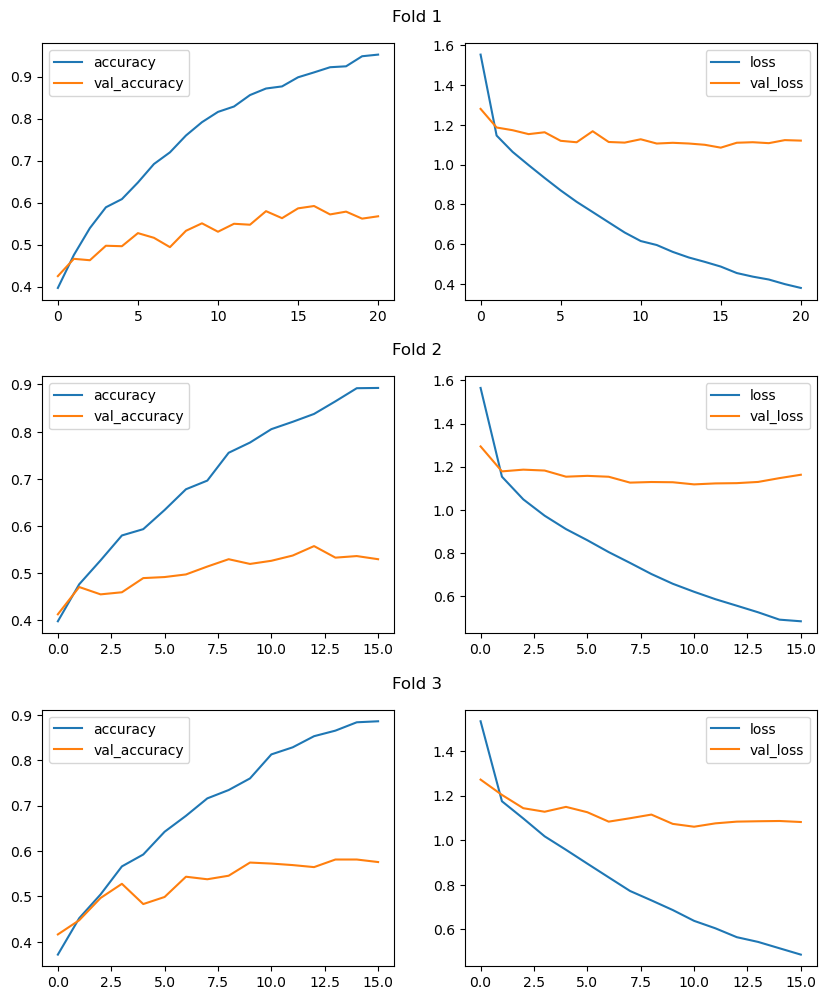

In [149]:
plot_history(histories)

In [150]:
print(report)

              precision    recall  f1-score   support

           2       0.55      0.57      0.56       775
           4       0.61      0.60      0.60      1420
           8       0.45      0.43      0.44       501

    accuracy                           0.56      2696
   macro avg       0.54      0.54      0.54      2696
weighted avg       0.56      0.56      0.56      2696



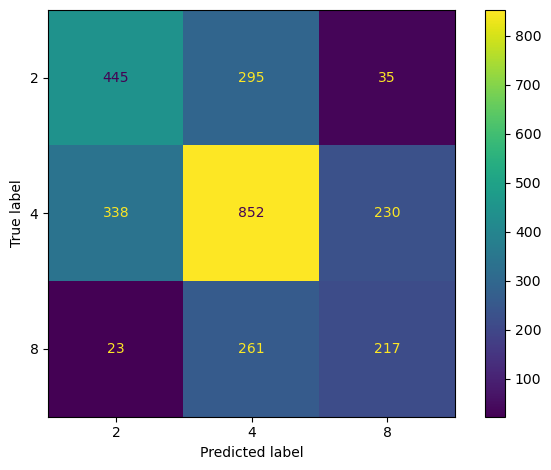

In [151]:
disp.plot()
plt.tight_layout()

## block13_sepconv2_act

In [152]:
histories, report, disp = extract_train_predict_cv('block13_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.3386 - loss: 1.3190 - val_accuracy: 0.4016 - val_loss: 1.2230
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4539 - loss: 1.1451 - val_accuracy: 0.4638 - val_loss: 1.1657
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5026 - loss: 1.0982 - val_accuracy: 0.4828 - val_loss: 1.1360
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5718 - loss: 1.0293 - val_accuracy: 0.4961 - val_loss: 1.1205
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6290 - loss: 0.9812 - val_accuracy: 0.4917 - val_loss: 1.1094
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6536 - loss: 0.9146 - val_accuracy: 0.4750 - val_loss: 1.1305
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6625 - loss: 0.9022 - val_accu

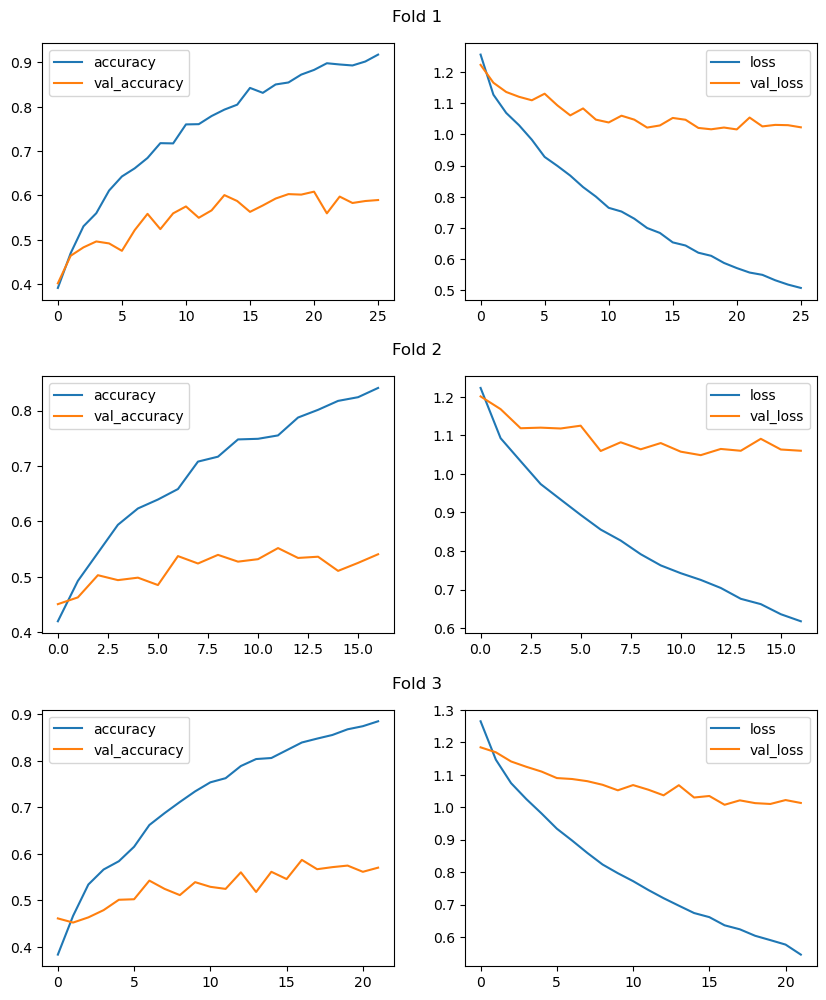

In [153]:
plot_history(histories)

In [154]:
print(report)

              precision    recall  f1-score   support

           2       0.57      0.62      0.60       775
           4       0.62      0.62      0.62      1420
           8       0.50      0.41      0.45       501

    accuracy                           0.58      2696
   macro avg       0.56      0.55      0.55      2696
weighted avg       0.58      0.58      0.58      2696



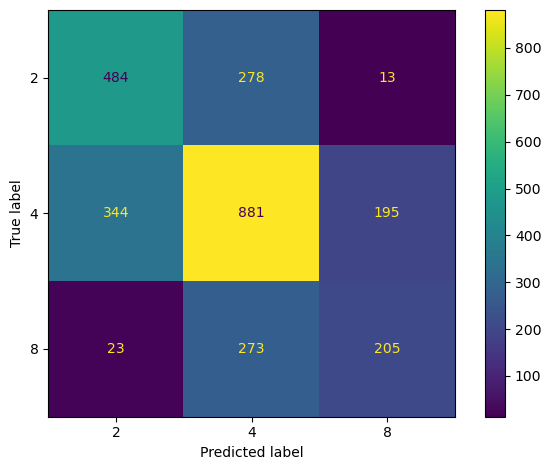

In [155]:
disp.plot()
plt.tight_layout()

## block13_sepconv2

In [164]:
histories, report, disp = extract_train_predict_cv('block13_sepconv2', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
Shape of features: (2696, 8, 8, 1024)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.4119 - loss: 1.3474 - val_accuracy: 0.4438 - val_loss: 1.1907
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5135 - loss: 1.1109 - val_accuracy: 0.4928 - val_loss: 1.1496
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5206 - loss: 1.0720 - val_accuracy: 0.5150 - val_loss: 1.1186
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5461 - loss: 1.0239 - val_accuracy: 0.5083 - val_loss: 1.1294
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5891 - loss: 0.9889 - val_accuracy: 0.4750 - val_loss: 1.1685
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5605 - loss: 0.9964 - val_accuracy: 0.5284 - val_loss: 1.0956
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6110 - loss: 0.9217 - val_acc

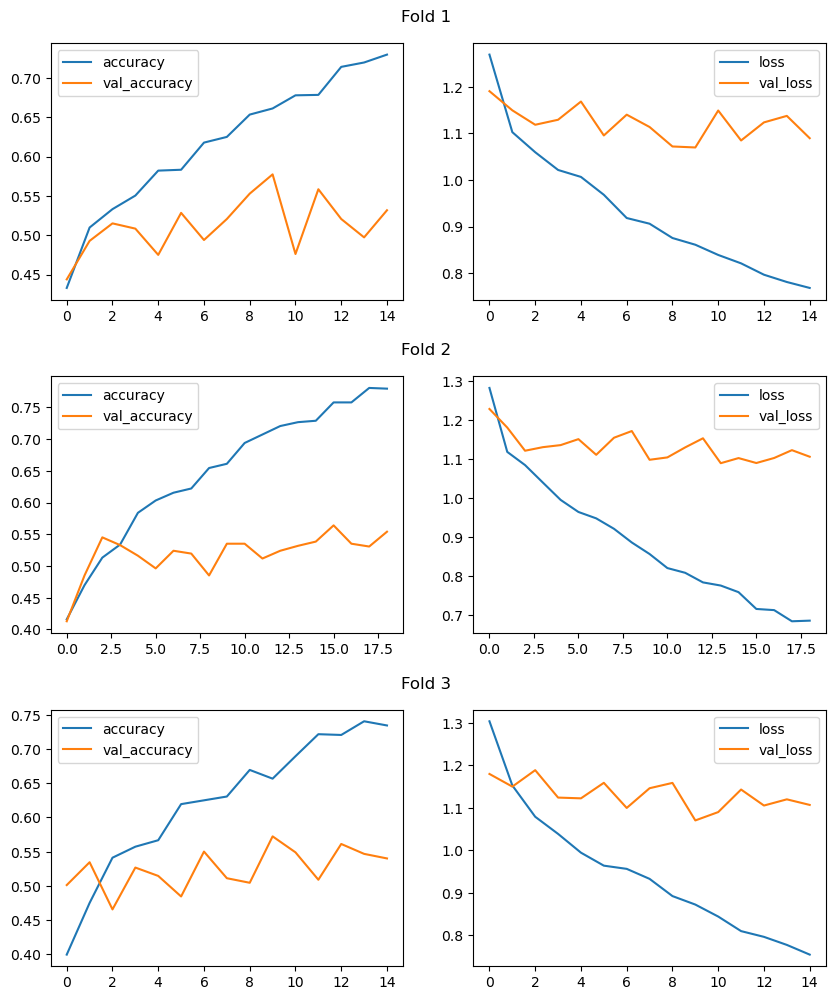

In [165]:
plot_history(histories)

In [166]:
print(report)

              precision    recall  f1-score   support

           2       0.52      0.65      0.58       775
           4       0.61      0.56      0.58      1420
           8       0.50      0.44      0.46       501

    accuracy                           0.56      2696
   macro avg       0.54      0.55      0.54      2696
weighted avg       0.56      0.56      0.56      2696



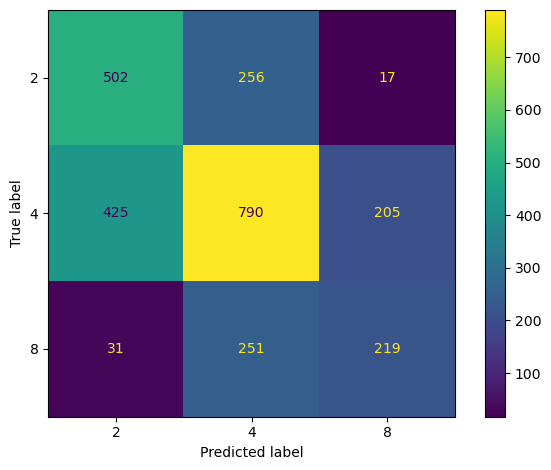

In [167]:
disp.plot()
plt.tight_layout()

## block14_sepconv1_act

In [156]:
histories, report, disp = extract_train_predict_cv('block14_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
Shape of features: (2696, 4, 4, 1536)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.3615 - loss: 1.2430 - val_accuracy: 0.4672 - val_loss: 1.1696
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4398 - loss: 1.1650 - val_accuracy: 0.4727 - val_loss: 1.1464
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4738 - loss: 1.1289 - val_accuracy: 0.5006 - val_loss: 1.1039
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4844 - loss: 1.0890 - val_accuracy: 0.4839 - val_loss: 1.1013
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5447 - loss: 1.0457 - val_accuracy: 0.4661 - val_loss: 1.1086
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4915 - loss: 1.0447 - val_accuracy: 0.5161 - val_loss: 1.0658
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5565 - loss: 0.9845 - val_acc

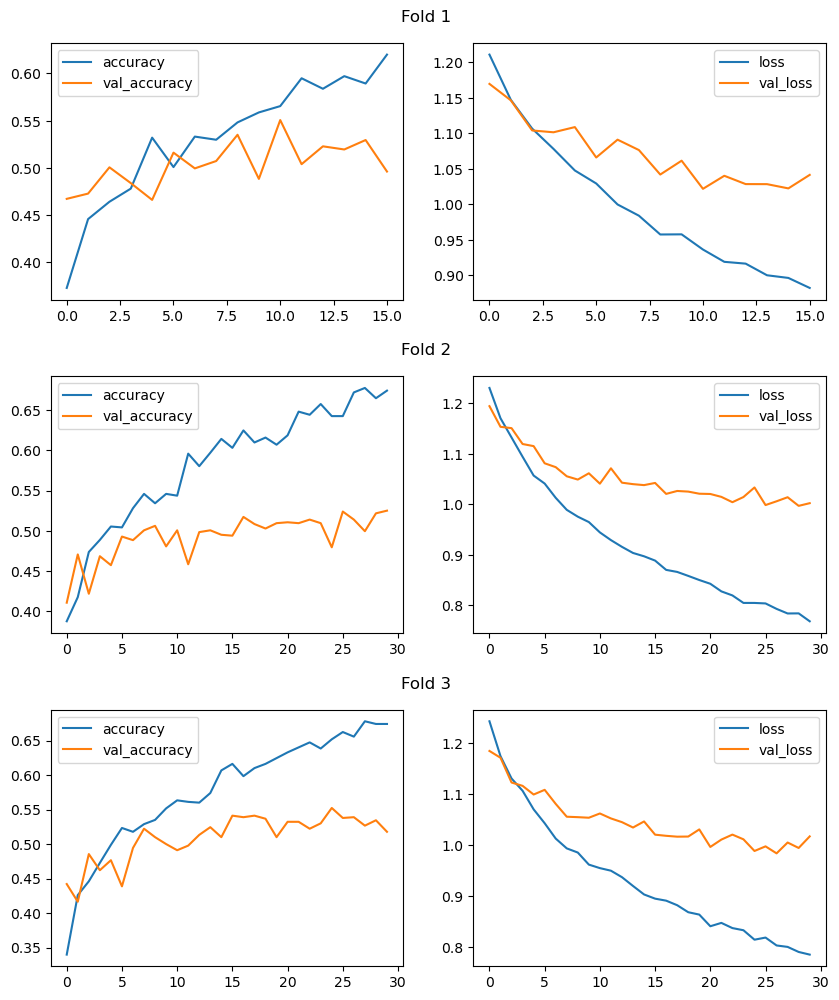

In [157]:
plot_history(histories)

In [158]:
print(report)

              precision    recall  f1-score   support

           2       0.51      0.65      0.57       775
           4       0.61      0.49      0.54      1420
           8       0.45      0.50      0.47       501

    accuracy                           0.54      2696
   macro avg       0.52      0.55      0.53      2696
weighted avg       0.55      0.54      0.54      2696



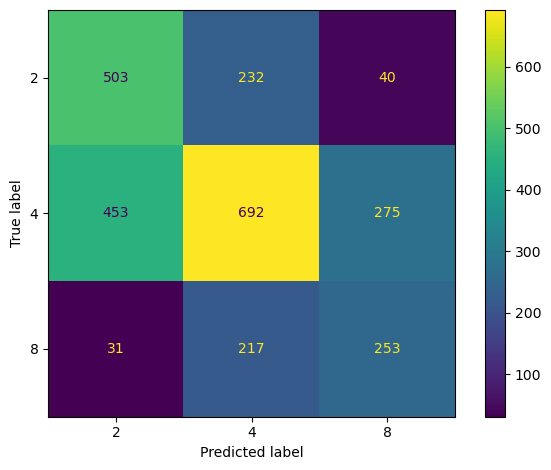

In [159]:
disp.plot()
plt.tight_layout()

## block14_sepconv2_act

In [160]:
histories, report, disp = extract_train_predict_cv('block14_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
Shape of features: (2696, 4, 4, 2048)
Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.3652 - loss: 1.4162 - val_accuracy: 0.4983 - val_loss: 1.1269
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4492 - loss: 1.1556 - val_accuracy: 0.4349 - val_loss: 1.1644
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4672 - loss: 1.1104 - val_accuracy: 0.4872 - val_loss: 1.0970
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4838 - loss: 1.0865 - val_accuracy: 0.5139 - val_loss: 1.0833
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5230 - loss: 1.0500 - val_accuracy: 0.5339 - val_loss: 1.0711
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5610 - loss: 0.9895 - val_accuracy: 0.4972 - val_loss: 1.0856
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5822 - loss: 0.9630 - val_acc

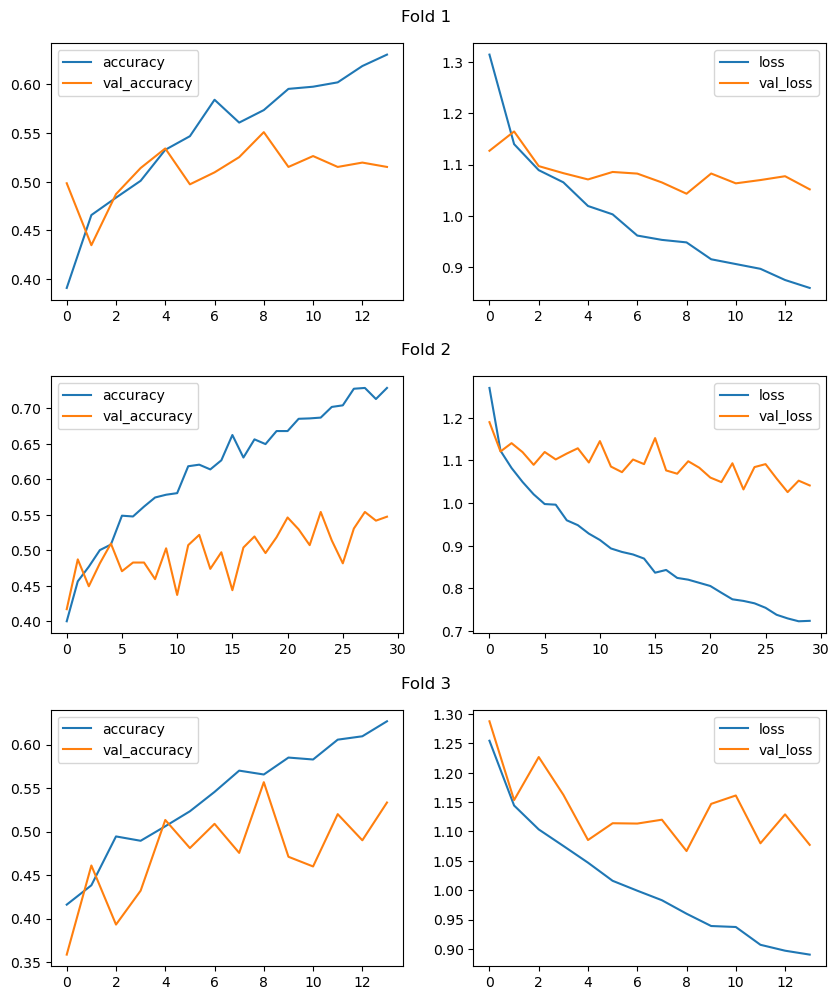

In [161]:
plot_history(histories)

In [162]:
print(report)

              precision    recall  f1-score   support

           2       0.53      0.53      0.53       775
           4       0.61      0.59      0.60      1420
           8       0.45      0.50      0.47       501

    accuracy                           0.55      2696
   macro avg       0.53      0.54      0.53      2696
weighted avg       0.56      0.55      0.55      2696



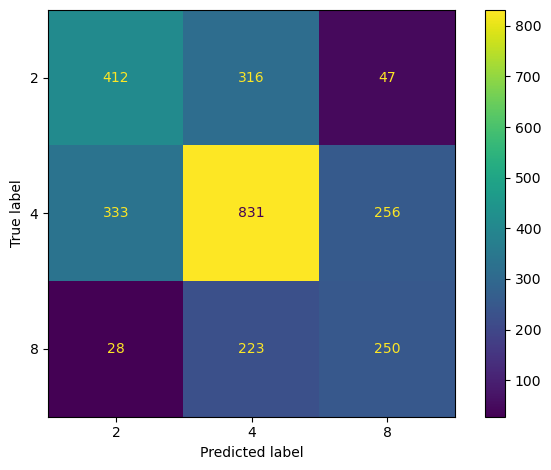

In [163]:
disp.plot()
plt.tight_layout()

## Test adding block 6 embeddings

In [83]:
import re
pattern = r'(^block6).*(act$)'
layers = [layer.name for layer in base_model.layers if re.search(pattern, layer.name)]
layers

['block6_sepconv1_act', 'block6_sepconv2_act', 'block6_sepconv3_act']

In [84]:
features = 0
for layer_name in layers:
    features += extract_features(layer_name)
print("Shape of features:", features.shape)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Shape of features: (2696, 8, 8, 728)


In [85]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
classes = np.unique(Y)
num_classes = len(classes)
fold_no = 1
all_preds = np.zeros((X.shape[0], num_classes))
histories = []
for train_index, val_index in cv.split(X=features,y=Y):
    model = build_model(None, features, num_classes)
    callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=5)
    print(f'Training on fold {fold_no}...')
    X_train, X_val = features[train_index], features[val_index]
    Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
    print("Class weights:", class_weights)
    class_weights_dict = dict(zip(np.unique(Y_train), class_weights))
    sample_weights = np.array([class_weights_dict[label] for label in Y_train])
    history = model.fit(X_train, Y_train, batch_size=32, epochs=30, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)
    histories.append(history)
    pred_soft = model.predict(X_val)
    all_preds[val_index] = pred_soft
    fold_no += 1
preds = np.argmax(all_preds, axis=1)

Training on fold 1...
Class weights: [1.15860735 0.63319239 1.79341317]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.3406 - loss: 1.7243 - val_accuracy: 0.4016 - val_loss: 1.2235
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4662 - loss: 1.0559 - val_accuracy: 0.5273 - val_loss: 0.9384
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5536 - loss: 0.8478 - val_accuracy: 0.4850 - val_loss: 0.9863
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6248 - loss: 0.7586 - val_accuracy: 0.5317 - val_loss: 0.9424
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6345 - loss: 0.6934 - val_accuracy: 0.5840 - val_loss: 0.8597
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7126 - loss: 0.6088 - val_accuracy: 0.5573 - val_loss: 0.8797
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7260 - loss: 0.5527 - val_accuracy: 0.5729 - val_loss: 0.8264
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

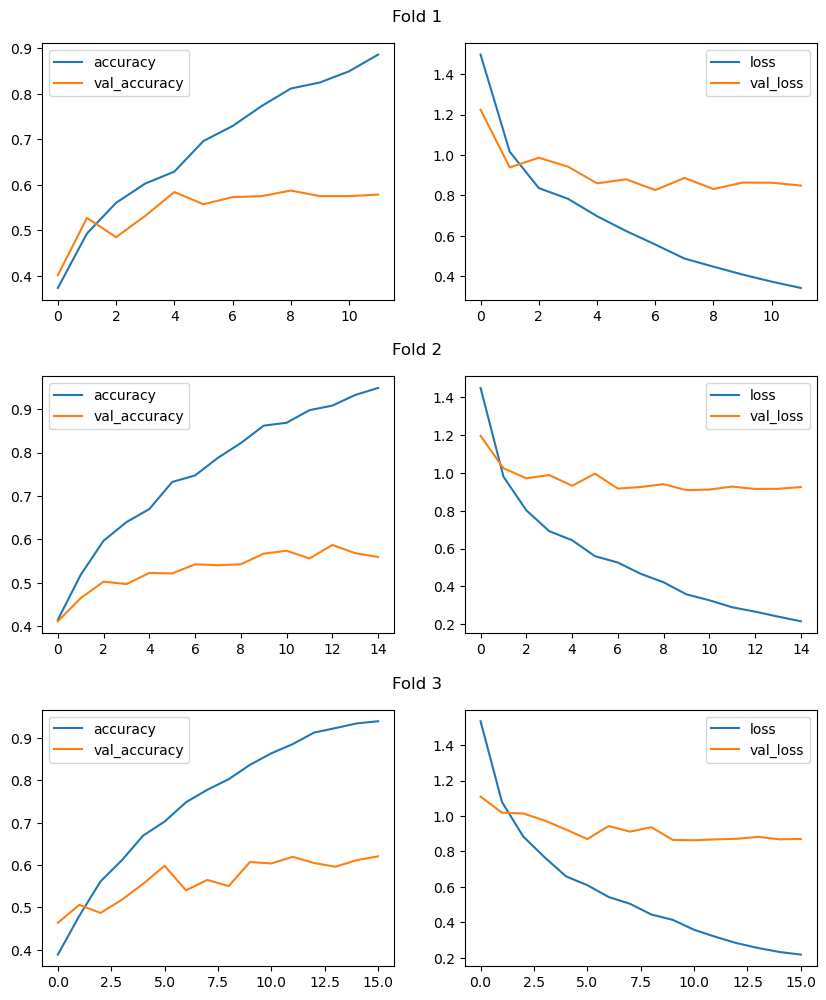

In [86]:
plot_history(histories)

In [87]:
print(classification_report(Y, preds, target_names=target_labels))

              precision    recall  f1-score   support

           2       0.57      0.60      0.59       775
           4       0.63      0.60      0.61      1420
           8       0.47      0.49      0.48       501

    accuracy                           0.58      2696
   macro avg       0.56      0.56      0.56      2696
weighted avg       0.58      0.58      0.58      2696



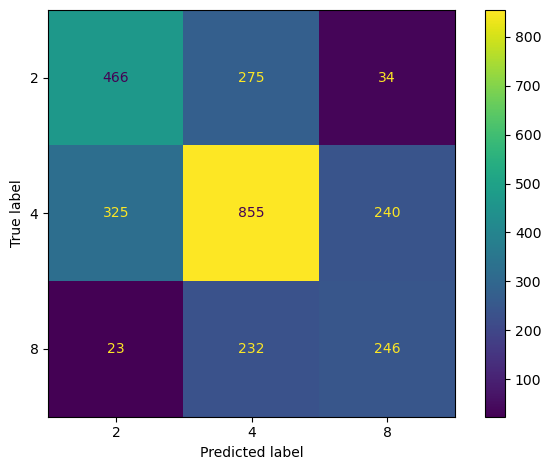

In [88]:
cm = confusion_matrix(Y, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
disp.plot()
plt.tight_layout()

Adding features does not lead to an increase in model performance

In [90]:
import random

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


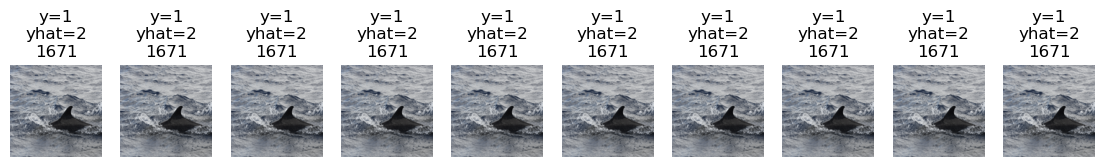

In [97]:
fig, ax = plt.subplots(1,10, figsize=(14,3))
i = 0
while i < 10:
    index = random.randrange(0, len(X))
    input_img = X[index]
    input_img += 1
    input_img /= 2
    # input_img *= 127.5
    input = features[index]
    input = np.expand_dims(input, axis=0)
    predictions = model.predict(input)
    j = 0
    while j < 100:
        yhat   = np.argmax(predictions[0])
        y      = Y.iloc[index]
        j += 1
        if yhat == y:
            # Prediction was correct. Ignore this example.
            continue
        else:
            # Prediction was incorrect. Show example.
            ax[i].imshow(input_img)
            ax[i].axis("off")
            ax[i].title.set_text('y=%d\nyhat=%d\n%d' % (y, yhat, index))
            i += 1
        if not i<10:
            break


In [101]:
print(labels.iloc[2588])

species                   melon_headed_whale
image            SIO_20071011-S45_4637b-.jpg
focus_clarity                            2.0
Name: 3484, dtype: object


In [ ]:
labels.iloc[]